<a href="https://colab.research.google.com/github/Ajay07pandey/AI_agent_LangGraph/blob/main/Agentic_Rag/Rag_Using_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip -q install langchain langchain-google-genai langchain-community langgraph python-dotenv faiss-cpu pypdf langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-a

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage,SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [22]:
import os
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [23]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [24]:
loader = PyPDFLoader("/content/NIPS-2017-attention-is-all-you-need-Paper.pdf")
docs = loader.load()

In [25]:
len(docs)

11

In [26]:
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=150)
chunks = splitter.split_documents(docs)

In [27]:
len(chunks)

53

In [28]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
vector = embeddings.embed_query("hello, world!")
vector[:5]

[-0.023955047, 0.011876456, -0.0033613679, -0.0584139, 0.0015592978]

In [29]:
vector_store = FAISS.from_documents(chunks, embeddings)

In [45]:
vector_store

In [46]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

| Search type                      | When to use                               | Best for                       | Strengths                      | Weaknesses                       | Recommended settings                     |
| -------------------------------- | ----------------------------------------- | ------------------------------ | ------------------------------ | -------------------------------- | ---------------------------------------- |
| **`similarity`**                 | Small corpus, clean data, low overlap     | FAQs, short docs               | Fast, simple, predictable      | Redundant chunks, poor diversity | `k=3–5`                                  |
| **`mmr`**                        | Overlapping chunks, long documents        | Knowledge bases, manuals       | Balances relevance + diversity | Slightly slower                  | `k=4`, `fetch_k=15–25`, `lambda=0.6–0.8` |
| **`similarity_score_threshold`** | Precision is critical, hallucination risk | Legal, policy, medical         | High accuracy, safer answers   | May return no results            | `threshold=0.75–0.85`, `k≤10`            |
| **Metadata-filtered similarity** | Multi-source or structured corpora        | Versioned docs, tenants        | Reduces noise early            | Requires good metadata           | `filter + similarity/MMR`                |
| **Hybrid (dense + sparse)**      | Large corpora, keyword-heavy queries      | Logs, tickets, code, IDs       | Best recall and precision      | Infra complexity                 | DB-dependent                             |
| **Parent–Child retrieval**       | Answers span multiple chunks              | Research, legal, manuals       | Rich context, fewer misses     | More storage & setup             | Child=300–500, Parent=1.5–3k             |
| **Multi-query retrieval**        | Short or vague user queries               | Conversational systems         | Improves recall                | Higher cost                      | 3–5 query rewrites                       |
| **Self-query retriever**         | Queries imply filters                     | Time, author, category queries | Automatic metadata filtering   | LLM dependency                   | Clean metadata required                  |


In [47]:
@tool
def rag_tool(query: str) -> str:
    """Retrieve relevant information from the pdf document."""
    result = retriever.invoke(query)
    # Joining contents into one string is often easier for the LLM to process
    return "\n\n".join([doc.page_content for doc in result])

In [48]:
# tool
# def rag_tool(query: str) -> dict:

#     """
#     Retrieve relevant information from the pdf document.
#     Use this tool when the user asks factual / conceptual questions
#     that might be answered from the stored documents.
#     """
#     result = retriever.invoke(query)

#     context = [doc.page_content for doc in result]
#     metadata = [doc.metadata for doc in result]

#     return {
#         'query': query,
#         'context': context,
#         'metadata': metadata
#     }

In [49]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)


Annotated[..., add_messages] (The "**Reducer**")

Normally, in a standard dictionary, if you have a list and you provide a new value, the old list is deleted and replaced by the new one. **add_messages** prevents this.

list[**BaseMessage**] means the messages key will hold a list of all chat interactions (Human messages, AI responses, and Tool results).

In [50]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [51]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

In [52]:
tool_node = ToolNode(tools)

In [53]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')#This says: "As soon as the user sends a message, go straight to the AI (chat_node)."
graph.add_conditional_edges('chat_node', tools_condition) # This is a "fork in the road." If the AI provides the answer it goes to the END,
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

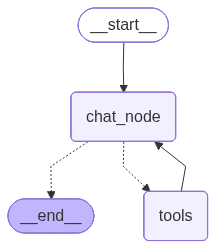

In [54]:
chatbot

In [55]:
result = chatbot.invoke({"messages": "What is a Multihead attention"})

In [56]:
result

{'messages': [HumanMessage(content='What is a Multihead attention', additional_kwargs={}, response_metadata={}, id='dd30df36-2236-46ce-a61e-d3f23420efd5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'rag_tool', 'arguments': '{"query": "Multihead attention"}'}, '__gemini_function_call_thought_signatures__': {'345997fa-6658-4577-9dc1-cb1156540d7f': 'CtACAXLI2nwWNxXMmgVy/QXJ06zX2Q/UlabvWAMI87enZWpvI//q+2ce0tF2ZNsNyFS7qiZNcgKRPjmEXtPLWTRtqWDzGaYmr6HVOC0gVxAn6XLy6GrNupQaLYRblE17gfTddDr3udpUs4LHFk67Z7cqDuBQiMLm19K89cui4kf1beE5qSyuIpCh57x60tbkQ6FzTPJr3a73t+XjK07v1icLAiYbe79rqexx9nlsDSGi8F5NT5ZJN4f9yZMO47wxoIMpXtlcsbx3WUZkKP6Hs39dCCnuAOBycq0VUVq82jzlt1Wj57H5mvXUPVO9QqwYYgqN+Xi1Qf2JGaZaG0TH23B7FGEDwTMQ7vQl/bVc1Dm2ZRIYRqQeDuwZ1Zdw9qIN4FMeYlEf3kltdpivkX8LiIO4zKG5QYOUIctqRki5vIA85c3+UbNiTSBg16cerqEIWweS'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019bc59e-bef8-7b60-a

In [57]:
result["messages"][-1].content

[{'type': 'text',
  'text': 'Multi-Head Attention is a mechanism that allows a model to jointly attend to information from different representation subspaces at different positions. Instead of performing a single attention function, it works by:\n\n1.  Linearly projecting the queries, keys, and values multiple (`h`) times using different, learned linear projections to lower dimensions (`dk`, `dk`, and `dv` respectively).\n2.  Performing the attention function in parallel on each of these projected versions, yielding `dv`-dimensional output values for each "head".\n3.  Concatenating these `h` output values.\n4.  Projecting the concatenated result once again to get the final values.\n\nThis approach is beneficial because a single attention head, by averaging, can inhibit the model\'s ability to attend to diverse information. Multi-Head Attention overcomes this by allowing the model to focus on different aspects of the input simultaneously.\n\nIn models like the Transformer, multi-head at